# [TEAM-X] Anime Recommender Engine - Keras Embeddings Implementation
#### NIKOLOPOULOS THOMAS 03085 - TSELOS ORFEAS-DIMITRIOS 02963
---

In this notebook (run in Google Collab) we will create a recommender system using the Embeddings technique available in the keras package.


An embedding refers to the conversion of a discrete, categorical variable into a continuous number vector. Within neural networks, embeddings are learned as low-dimensional, continuous vector representations of discrete variables. These neural network embeddings prove valuable by reducing the dimensionality of categorical variables and effectively representing categories in the transformed space.

In essence, embeddings empower machine learning models to identify comparable objects. When provided with a photo or document, a machine learning model using embeddings can locate a similar photo or document.

❗ **WARNING: DO NOT RUN BECAUSE OF EXTENDED TIME TO TRAIN THE MODEL. IT HAS ALREADY BEEN RUN.** ❗

## Feature Cleaning
---

Before we implement the recommender system, we will search for missing or duplicate values in the two datasets and remove them.

In [3]:
# Importing packages used in this notebook
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot, Dense, concatenate
from keras.models import Model
from sklearn.metrics import mean_squared_error
from math import sqrt
import multiprocessing

In [4]:
# Loading the datasets
ratings = pd.read_csv('rating.csv')
anime = pd.read_csv('anime.csv')

### Missing Values

In [5]:
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

We decide to drop the missing values, because their number is too small compared to the total number of entries.

In [6]:
anime = anime.dropna()
anime.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [7]:
ratings.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

There are no missing values.

### Duplicate Values

In [8]:
anime.duplicated().sum()

0

We see that there are no duplicate values.

In [9]:
ratings.duplicated().sum()

1

We see that there is 1 duplicate value.

In [10]:
ratings = ratings.drop_duplicates()
ratings.duplicated().sum()

0

Duplicate has been removed.

## Multiprocessing
---

As the training of the `rating.csv` dataset using Embeddings is time-consuming, we will take advantage of the multiprocessing module in Python to determine the number of available CPU cores.

In [11]:
num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 2


## Creating the Recommender System
---

We will implement the recommender system in stages to make the code understandable and easier to modify if needed.

### Preprocessing and Initialisations

In [12]:
# Preprocess data
n_users = ratings['user_id'].nunique()
n_animes = ratings['anime_id'].nunique()

# Ensure that the embedding size is smaller than the number of unique users and animes
embedding_size = min(50, n_users, n_animes)

### Mapping indices

In [13]:
# Map user and anime indices to a range starting from 0
user_mapping = {user_id: i for i, user_id in enumerate(ratings['user_id'].unique())}
anime_mapping = {anime_id: i for i, anime_id in enumerate(ratings['anime_id'].unique())}

ratings['user_index'] = ratings['user_id'].map(user_mapping)
ratings['anime_index'] = ratings['anime_id'].map(anime_mapping)

### Input, Embedding and Flatten Layers

In [14]:
# Create user and anime input layers
user_input = Input(shape=(1,), name='user_input')
anime_input = Input(shape=(1,), name='anime_input')

# User and anime embeddings
user_embedding = Embedding(n_users, embedding_size, input_length=1, name='user_embedding')(user_input)
anime_embedding = Embedding(n_animes, embedding_size, input_length=1, name='anime_embedding')(anime_input)

# Flatten the embeddings
user_flat = Flatten()(user_embedding)
anime_flat = Flatten()(anime_embedding)

### Dot product and merge

---



In [15]:
# Dot product of user and anime embeddings
dot_product = Dot(axes=1, name='dot_product')([user_flat, anime_flat])

# Combine user and anime embeddings
merged = concatenate([user_flat, anime_flat])

### Model Creation

In [16]:
# Model creation
model = Model(inputs=[user_input, anime_input], outputs=dot_product)
model.compile(optimizer='adam', loss='mean_squared_error')

### Training and Test Split

In [17]:
# Split the data into training and testing sets
train, test = train_test_split(ratings, test_size=0.8, random_state=42)

### Model training and evaluation

Model training for the `rating.csv` dataset is very time-consuming (ETA: 1 hour, 50 minutes). The results can be seen below so rerunning is not necessary.

In [18]:
# Model training
history = model.fit([train['user_index'], train['anime_index']], train['rating'], epochs=5, batch_size=64, validation_split=0.2, workers=num_cores)

# Model evaluation on the test set
predictions = model.predict([test['user_index'], test['anime_index']])
rmse = sqrt(mean_squared_error(test['rating'], predictions))
print(f'Root Mean Squared Error on Test Set: {rmse}')

Epoch 1/5
19535/19535 [==============================] - 1427s 73ms/step - loss: 23.9440 - val_loss: 8.1237
Epoch 2/5
19535/19535 [==============================] - 1299s 67ms/step - loss: 6.4610 - val_loss: 6.4695
Epoch 3/5
19535/19535 [==============================] - 1298s 66ms/step - loss: 5.4019 - val_loss: 6.0104
Epoch 4/5
19535/19535 [==============================] - 1280s 66ms/step - loss: 4.7661 - val_loss: 5.7783
Epoch 5/5
195344/195344 [==============================] - 262s 1ms/step
Root Mean Squared Error on Test Set: 2.375569190887663


### Saving the model and plotting the Errors-Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0.5, 1.0, 'Errors per Epoch')

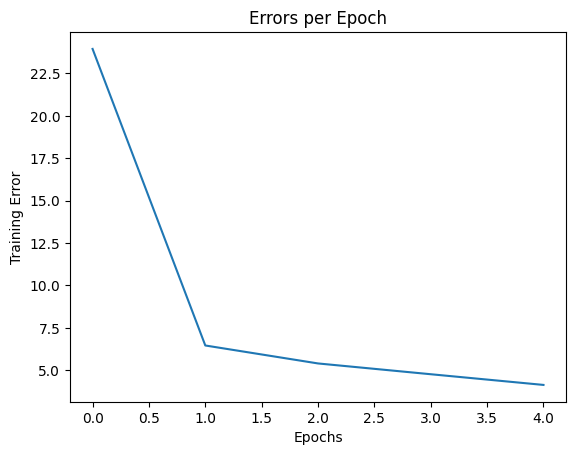

In [20]:
model.save('recommender_model.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")
plt.title("Errors per Epoch")

### Recommender Function

In [21]:
def recommender(user_id, model, anime_mapping, anime, n):
    # Get the index of the user
    user = user_mapping[user_id]

    # Get anime indices
    anime_indices = np.array(list(anime_mapping.values()))

    # Repeat the user index for all anime
    user_indices = np.full_like(anime_indices, user)

    # Predict ratings for all anime for the given user
    predictions = model.predict([user_indices, anime_indices])

    # Get the original anime IDs
    anime_ids = [anime_id for anime_id, idx in anime_mapping.items()]

    # Create a dataFrame with anime IDs, predicted ratings, and other anime information from anime.csv
    recommendations = pd.DataFrame({
        'anime_id': anime_ids,
        'predicted_rating': predictions.flatten()
    })

    # Merge with anime to get additional information
    recommendations = pd.merge(recommendations, anime, on='anime_id')

    # Sort the DataFrame by predicted ratings in descending order
    recommendations = recommendations.sort_values(by='predicted_rating', ascending=False)

    # Get the top N recommendations
    top_recommendations = recommendations.head(n)

    return top_recommendations


### Calling the recommender for a specific `user_id`

In [22]:
user_id = 123  # Replace with the desired user ID
n = 10 # Replace with the desired number of recommended anime
top_recommendations = recommender(user_id, model, anime_mapping, anime, n)

print(f"Top {n} recommended anime for user {user_id}:")
print(top_recommendations)

350/350 [==============================] - 1s 1ms/step
Top 10 recommended anime for user 123:
      anime_id  predicted_rating                           name  \
2704       820         11.286757           Ginga Eiyuu Densetsu   
429       9253         10.916918                    Steins;Gate   
494      14719         10.789021  JoJo no Kimyou na Bouken (TV)   
443      10162         10.759461                     Usagi Drop   
1536     21939         10.648460             Mushishi Zoku Shou   
565      22789         10.626290                      Barakamon   
882         19         10.609235                        Monster   
436       9969         10.544785                  Gintama&#039;   
227      30276         10.498508                  One Punch Man   
328        918         10.465157                        Gintama   

                                                  genre type episodes  rating  \
2704                     Drama, Military, Sci-Fi, Space  OVA      110    9.11   
429   

## Conclusion

This notebook has guided us to the recommendation of a number of anime for a specific user. With the help of Embeddings, we have sucessfully created a Recommender System in Python.